#### Datasets

**train_set.csv**: in the training dataset you will find a list of hotels and hotel characteristics. Every row has a unique identifier for the hotel - the hotel_id. The column n_clicks specifies the number of clicks the hotel has received in a specified time frame. This is the target variable you have to predict.
Number of rows: 396487.

**test_set.csv**: in the test set you will find a list of new hotels with the same characteristics as in the training set and derived in the same time frame. In this dataset the target variable that you have to predict is missing.
Number of rows: 132162.

**sample_submission.csv**: an example submission file. It should contain only the unique hotel_ids from the test set and the number of predicted clicks.


The training dataset provided is not clean and may be missing data or contain nonsensical values. Also, the datasets below contain potentially hashed and/or modified values. 



#### Evaluation

The predictions will be evaluated by a normalized weighted mean square error. Find more details in the resource section.

#### Column description

**hotel_id**: a number uniquely identifying each hotel

**city_id**: describes the city the hotel is located in

**content_score**: describes the quality of the content that is provided 
for the hotel on a scale from 0 (worst) to 100 (best)

**n_images**: number of images that are available for the given hotel

**distance_to_center**: distance (in meters) of the hotel to the nearest city center

**avg_rating**: average rating of the hotel on a scale from 0 (worst) to 100 (best)

**n_reviews**: number of reviews that are available for that hotel

**avg_rank**: average position the hotel had in the list

**avg_price**: average price in Euro of the hotel

**avg_saving_percent**: average saving users achieve on this hotel by using aggregator, i.e. the relative difference between the cheapest and most expensive deal for the hotel

**n_clicks**: the number of clicks the hotel has received in a specific time frame (target variable, unique to the training set)

In [1]:
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
sns.set()

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold,train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error,mean_squared_error

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
import xgboost as xgb
import lightgbm as lgb

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
# Train data

df = pd.read_csv("../Hotel_Clicks_Prediction/train_set.csv")
df.head(5)

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4
2,9.811544e+10,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44
3,9.824279e+10,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4
4,9.833438e+10,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10


In [3]:
# Test data

df_test = pd.read_csv("../Hotel_Clicks_Prediction/test_set.csv")
IDtest = df_test["hotel_id"]
df_test.head(5)

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent
0,14942256073,122750.0,58.0,2.0,11503.0,89.0,0.0,168.0,13.500,90.19,32.0
1,16036037903,28134.0,68.0,4.0,938.0,81.0,5.0,735.0,13.667,98.27,19.0
2,288585940112,30578.0,19.0,0.0,38982.0,NaN,0.0,0.0,20.462,48.77,0.0
3,129041645070,54398.0,47.0,0.0,1683.0,80.0,0.0,69.0,15.000,72.32,0.0
4,12460296563,63890.0,59.0,3.0,1299.0,80.0,3.0,1470.0,10.000,24.54,19.0


In [4]:
# Check how clean our test and train data

df_test.isnull().sum()

hotel_id                  0
city_id                 155
content_score           155
n_images                156
distance_to_center      163
avg_rating            36630
stars                   175
n_reviews               163
avg_rank                  0
avg_price                58
avg_saving_percent       58
dtype: int64

In [5]:
df.isnull().sum()

hotel_id                   0
city_id                  508
content_score            508
n_images                 509
distance_to_center       529
avg_rating            110398
stars                    562
n_reviews                529
avg_rank                   0
avg_price                170
avg_saving_percent       170
n_clicks                   0
dtype: int64

In [6]:
# Test data has one column less

df.shape, df_test.shape

((396487, 12), (132162, 11))

In [7]:
len(df.hotel_id.unique()),len(df_test.hotel_id.unique())

(396487, 132162)

The number of unique hotel_id is equal to the number of samples, which along with zero Nan values on the column indicates that dataset contains no hotel repetitions. As the result, I think that this feature can further be neglected for  analysis

In [8]:
df = df.drop(['hotel_id'], axis=1)
df_test = df_test.drop(['hotel_id'], axis=1)

In [9]:
len(df.city_id.unique())

33214

### 1) Exploratory data analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396487 entries, 0 to 396486
Data columns (total 11 columns):
city_id               395979 non-null float64
content_score         395979 non-null float64
n_images              395978 non-null float64
distance_to_center    395958 non-null float64
avg_rating            286089 non-null float64
stars                 395925 non-null float64
n_reviews             395958 non-null float64
avg_rank              396487 non-null float64
avg_price             396317 non-null float64
avg_saving_percent    396317 non-null float64
n_clicks              396487 non-null int64
dtypes: float64(10), int64(1)
memory usage: 33.3 MB


In [11]:
# Lets have a look at statistics of train set, to look for outliers.

df.describe()

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
count,395979.000000,395979.000000,3.959780e+05,3.959580e+05,286089.000000,395925.000000,395958.000000,396487.000000,396317.000000,396317.000000,396487.000000
mean,149193.465376,50.992795,2.593212e+02,1.634383e+04,81.616525,1.159659,913.667419,14.694502,109.332048,7.179601,13.781980
std,219189.285044,11.563444,1.731682e+04,2.752200e+05,6.025140,1.619713,2432.494160,5.604578,148.198851,13.081529,123.572896
min,2.000000,7.000000,-1.000000e+00,0.000000e+00,34.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000
25%,32014.000000,45.000000,0.000000e+00,5.440000e+02,79.000000,0.000000,0.000000,11.091000,51.050000,0.000000,0.000000
50%,55122.000000,53.000000,1.000000e+00,1.516000e+03,83.000000,0.000000,189.000000,15.000000,77.650000,0.000000,0.000000
75%,137464.000000,59.000000,2.000000e+00,4.163000e+03,86.000000,3.000000,777.000000,18.375000,120.930000,10.000000,2.000000
max,878736.000000,81.000000,2.393911e+06,1.834155e+07,97.000000,5.000000,283089.000000,100.000000,8000.000000,99.000000,13742.000000


From the brief data description we could easily detect number of outliers, for instance in `n_images` and `n_reviews` columns. Therefore the reasonable step is to get rid of them. The max values for `n_clicks` and `avg_price` can also be tested

In [12]:
df["n_clicks"].min(),df["n_clicks"].max()

(0, 13742)

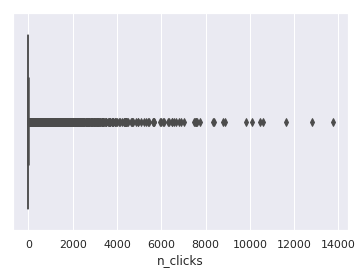

In [13]:
# Boxplot

sns.boxplot(df['n_clicks'])

In [14]:
df[df['n_clicks']>10000]

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
119549,13278.0,63.0,6.0,294.0,86.0,5.0,15828.0,5.297,137.70,30.0,11652
143912,30512.0,63.0,1.0,4857.0,86.0,5.0,909.0,8.946,346.96,54.0,12790
201233,8582.0,66.0,12.0,1715.0,80.0,4.0,18861.0,9.603,109.85,18.0,10108
211064,170898.0,50.0,1.0,1317.0,82.0,5.0,339.0,4.471,143.88,22.0,10592
211753,8582.0,69.0,11.0,2058.0,86.0,4.0,13404.0,7.381,137.61,21.0,13742
395410,27328.0,60.0,5.0,811.0,85.0,4.0,2556.0,8.731,170.42,36.0,10458


In [15]:
df["avg_price"].min(),df["avg_price"].max()

(4.0, 8000.0)

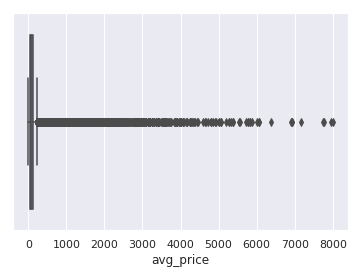

In [16]:
sns.boxplot(x = df['avg_price'])

In [17]:
df[df['avg_price']>7000]

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
29242,54398.0,47.0,0.0,6451.0,84.0,0.0,216.0,15.00,8000.00,0.0,0
107649,146568.0,19.0,0.0,53508.0,NaN,0.0,0.0,14.75,7162.37,0.0,0
155038,174248.0,42.0,0.0,11541.0,NaN,0.0,0.0,11.00,7773.74,0.0,0
240112,52306.0,42.0,0.0,2607.0,NaN,0.0,0.0,14.50,7741.74,0.0,0
314247,44036.0,42.0,0.0,1156.0,NaN,0.0,0.0,3.00,7957.34,0.0,0


Seems like a few hotels with average price above 7000 might be outlier or some data mining mistake. Because the price is very high, no info about `stars`, `n_images` very low `avg_rank` etc..I think these hotels might be deleted from the training set.

Next step is analyze features a bit, to find which one correlates at most with `n_clicks`. Let say top-10 samples w.r.t `n_clicks`

city_id
7696.0     205858
8582.0     195422
55122.0    105106
13278.0     94864
3606.0      90344
27366.0     56060
34798.0     54218
44470.0     50838
18760.0     49128
27328.0     45106
Name: n_clicks, dtype: int64


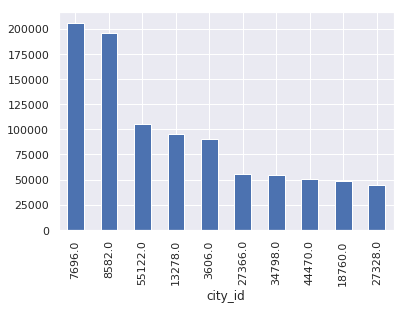

In [18]:
# top-10 cities with most number of clicks

df.groupby('city_id')['n_clicks'].sum().sort_values(ascending=False).iloc[:10].plot(kind='bar')
print(df.groupby('city_id')['n_clicks'].sum().sort_values(ascending=False).iloc[:10])

city_id
50168.0    192516.0
44470.0    121841.0
34798.0    110118.0
30576.0    101001.0
26874.0     83287.0
46884.0     72344.0
31786.0     72014.0
53222.0     64111.0
53604.0     60811.0
63440.0     58504.0
Name: avg_rating, dtype: float64


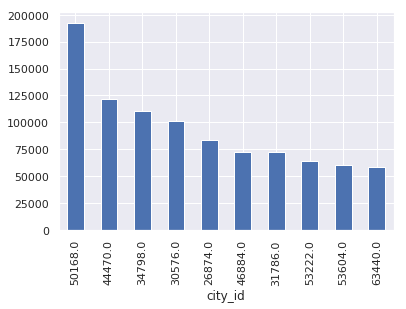

In [19]:
df.groupby('city_id')['avg_rating'].sum().sort_values(ascending=False).iloc[:10].plot(kind='bar')
print(df.groupby('city_id')['avg_rating'].sum().sort_values(ascending=False).iloc[:10])

We could see that the cities with the hotels having most `n_clicks` in the majority if the cases are not the same as those whose hotels have a higher rating. Basically, it implies that people and clicking more on the hotels in the cities with lower `avg_rating`, which is sort of counter-intuitive.

Let us have a look on top - 10 values of distances to the center feature.
I would expect to have in top-10 very small values (short distance to the center is more
attractive, hence more clickable)

distance_to_center
0.0       20050
294.0     14682
2058.0    13958
4857.0    13566
811.0     12818
1317.0    12806
1017.0    11838
741.0     11478
936.0     11204
1537.0    10750
Name: n_clicks, dtype: int64


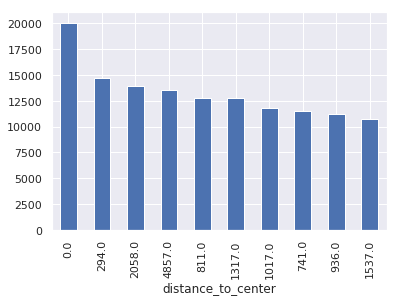

In [20]:
df.groupby('distance_to_center')['n_clicks'].sum().sort_values(ascending=False).iloc[:10].plot(kind='bar')
print(df.groupby('distance_to_center')['n_clicks'].sum().sort_values(ascending=False).iloc[:10])

#### 1.4) Correlation matrix

To spped up the features analysis we will check the correlation between numerical features in our data set between themselves and the number of clicks. This information is important to know as there are Machine Learning algorithms (for example, linear and logistic regression) that do not handle highly correlated input variables well.

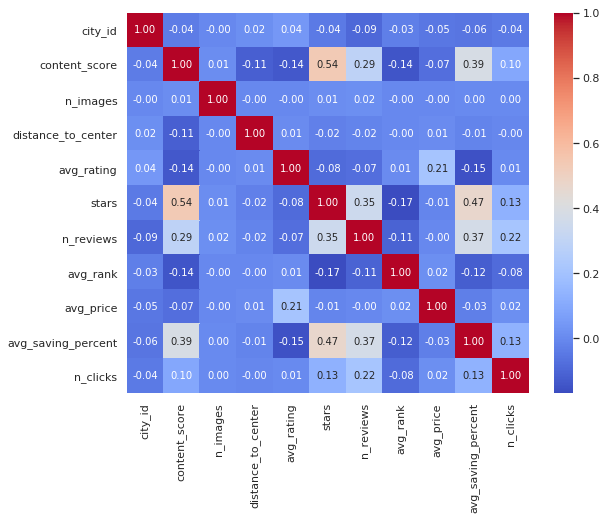

In [21]:
plt.figure(figsize=(9, 7))
g = sns.heatmap(df[[ u'city_id', u'content_score', u'n_images',
       u'distance_to_center', u'avg_rating', u'stars', u'n_reviews',
       u'avg_rank', u'avg_price', u'avg_saving_percent', u'n_clicks']].corr(), 
                annot=True,fmt = ".2f", cmap = "coolwarm")

A few features seems to correlate with `n_clicks`: `n_reviews`, `avg_saving_percent`,`content_score`,`stars`,`avg_rank`. But we do not really have linearly correlated features, which prevents us from multicollinearity scenario.

From the correlation matrix, we could see that feature `stars` highly correlates with: `n_reviews`, `content score`,`saving percent`. At the same time, exactly these features correlate at most with `n_clicks`. Therefore we do expect them to have a high contribution to the regression model. 

### 1. 4) Outliers

Additionally, we do see a number of outliers from the box plots, however, would be correct to analyze is statistically through IQR.

In [22]:
# Analyze outliers with H- spread

def outliers(df):

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    
    df_clear = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    df_clear.reset_index(drop=True, inplace=True)
    
    return df_clear

In [23]:
data_tukey = outliers(df)
data_tukey.shape

city_id               105450.000
content_score             14.000
n_images                   2.000
distance_to_center      3619.000
avg_rating                 7.000
stars                      3.000
n_reviews                777.000
avg_rank                   7.284
avg_price                 69.880
avg_saving_percent        10.000
n_clicks                   2.000
dtype: float64


(182689, 11)

Train data is being dramatically reduced by applying the Tukey method. I would consider losing almost $50\%$ of the data as a huge loss, therefore we will proceed with more specific outliers removal. 

In [24]:
df.describe()

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
count,395979.000000,395979.000000,3.959780e+05,3.959580e+05,286089.000000,395925.000000,395958.000000,396487.000000,396317.000000,396317.000000,396487.000000
mean,149193.465376,50.992795,2.593212e+02,1.634383e+04,81.616525,1.159659,913.667419,14.694502,109.332048,7.179601,13.781980
std,219189.285044,11.563444,1.731682e+04,2.752200e+05,6.025140,1.619713,2432.494160,5.604578,148.198851,13.081529,123.572896
min,2.000000,7.000000,-1.000000e+00,0.000000e+00,34.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000
25%,32014.000000,45.000000,0.000000e+00,5.440000e+02,79.000000,0.000000,0.000000,11.091000,51.050000,0.000000,0.000000
50%,55122.000000,53.000000,1.000000e+00,1.516000e+03,83.000000,0.000000,189.000000,15.000000,77.650000,0.000000,0.000000
75%,137464.000000,59.000000,2.000000e+00,4.163000e+03,86.000000,3.000000,777.000000,18.375000,120.930000,10.000000,2.000000
max,878736.000000,81.000000,2.393911e+06,1.834155e+07,97.000000,5.000000,283089.000000,100.000000,8000.000000,99.000000,13742.000000


#### Average Price

Above we have already discussed the samples with `avg_price` bigger than 7000, let's remove them.

In [25]:
df[df['avg_price']>7000]

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
29242,54398.0,47.0,0.0,6451.0,84.0,0.0,216.0,15.00,8000.00,0.0,0
107649,146568.0,19.0,0.0,53508.0,NaN,0.0,0.0,14.75,7162.37,0.0,0
155038,174248.0,42.0,0.0,11541.0,NaN,0.0,0.0,11.00,7773.74,0.0,0
240112,52306.0,42.0,0.0,2607.0,NaN,0.0,0.0,14.50,7741.74,0.0,0
314247,44036.0,42.0,0.0,1156.0,NaN,0.0,0.0,3.00,7957.34,0.0,0


In [26]:
df = df.drop(df[df['avg_price']>7000].index)

#### Number of Images

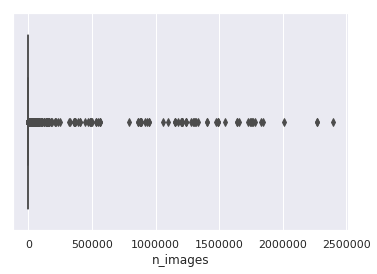

In [27]:
sns.boxplot(x=df['n_images'])

In [28]:
df[df['n_images']>2000000]

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
26198,84192.0,58.0,2270985.0,1549.0,87.0,2.0,1356.0,9.0,71.50,7.0,0
318392,29682.0,61.0,2269427.0,17271.0,82.0,2.0,7878.0,16.5,95.01,10.0,0
321831,29848.0,62.0,2007288.0,8922.0,87.0,3.0,6921.0,17.0,84.98,9.0,0
364534,104086.0,59.0,2393911.0,574.0,85.0,2.0,3090.0,20.0,143.31,10.0,0


Even though the number of images above 2 mln for the hotel seems to be ridiculously big, there are no reasons to remove these rows from the data set.

#### Number of reviews
Also, the maximum value of `n_reviews` looks suspicious. 

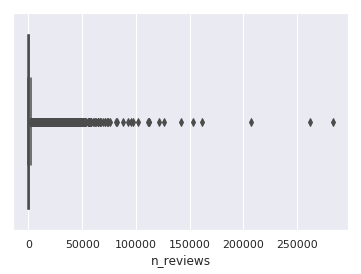

In [29]:
sns.boxplot(x=df['n_reviews'])

In [30]:
df[df['n_reviews']>150000]

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
49900,29468.0,66.0,8.0,1114.0,55.0,2.0,153039.0,7.228,178.98,43.0,910
82569,29334.0,64.0,11.0,391.0,69.0,3.0,161541.0,8.961,108.23,37.0,386
142141,29334.0,62.0,11.0,1560.0,73.0,3.0,261816.0,10.071,81.34,27.0,886
202741,29334.0,69.0,10.0,1336.0,81.0,4.0,207075.0,5.842,106.93,35.0,954
322638,29334.0,62.0,13.0,1940.0,75.0,4.0,283089.0,8.147,93.16,31.0,1534


Four out of five cities with highest amount of clicks have `city_id` equal to 29334. Let us have a closer look at this city id.

In [31]:
df[df['city_id'] == 29334].sort_values(by = 'n_reviews').head()

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
349724,29334.0,50.0,2.0,819.0,NaN,0.0,0.0,12.00,484.19,10.0,0
71436,29334.0,49.0,0.0,11528.0,NaN,0.0,0.0,9.25,59.56,0.0,0
260734,29334.0,45.0,0.0,8469.0,NaN,0.0,0.0,13.00,478.56,0.0,0
368451,29334.0,43.0,0.0,667.0,NaN,0.0,0.0,1.50,135.10,0.0,2
264052,29334.0,23.0,0.0,0.0,NaN,0.0,0.0,22.00,196.18,0.0,0


So we can observe that samples with a big amount of reviews seemed to be ok, and we will keep them in order to preserve the abilities of the model to generalize well on the test set. However the one can see that a lot of samples has almost no data and we will get rid of these samples.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396482 entries, 0 to 396486
Data columns (total 11 columns):
city_id               395974 non-null float64
content_score         395974 non-null float64
n_images              395973 non-null float64
distance_to_center    395953 non-null float64
avg_rating            286088 non-null float64
stars                 395920 non-null float64
n_reviews             395953 non-null float64
avg_rank              396482 non-null float64
avg_price             396312 non-null float64
avg_saving_percent    396312 non-null float64
n_clicks              396482 non-null int64
dtypes: float64(10), int64(1)
memory usage: 36.3 MB


In [33]:
# Almost 10,000 of this kind of samples

df[(df['n_images'] == 0) & (df['distance_to_center'] == 0)  & (df['avg_rating'].isnull()) & (df['stars'] == 0)
  & (df['n_reviews'] == 0) & (df['avg_saving_percent'] == 0) & (df['n_clicks'] == 0)].head()

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
913,341292.0,19.0,0.0,0.0,NaN,0.0,0.0,15.0,63.20,0.0,0
916,54246.0,20.0,0.0,0.0,NaN,0.0,0.0,19.0,93.60,0.0,0
2051,27172.0,23.0,0.0,0.0,NaN,0.0,0.0,7.0,82.46,0.0,0
2477,53180.0,19.0,0.0,0.0,NaN,0.0,0.0,23.0,49.71,0.0,0
2479,309452.0,17.0,0.0,0.0,NaN,0.0,0.0,20.0,85.60,0.0,0


In [34]:
df.shape

(396482, 11)

In [35]:
df = df.drop(df[(df['n_images'] == 0) & (df['distance_to_center'] == 0)  & (df['avg_rating'].isnull()) & (df['stars'] == 0)
  & (df['n_reviews'] == 0) & (df['avg_saving_percent'] == 0) & (df['n_clicks'] == 0)].index)

print(df.shape)

(386628, 11)


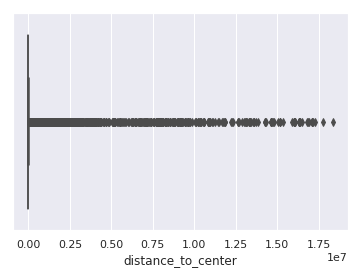

In [36]:
sns.boxplot(x=df['distance_to_center'])

So, other columns are pretty much ok, therefore we go to the next step, that is **data imputation**.

### 2) Filling missing values

In [37]:
df.isnull().sum()

city_id                  508
content_score            508
n_images                 509
distance_to_center       529
avg_rating            100540
stars                    562
n_reviews                529
avg_rank                   0
avg_price                170
avg_saving_percent       170
n_clicks                   0
dtype: int64

In [38]:
df_test.isnull().sum()

city_id                 155
content_score           155
n_images                156
distance_to_center      163
avg_rating            36630
stars                   175
n_reviews               163
avg_rank                  0
avg_price                58
avg_saving_percent       58
dtype: int64

In [39]:
df.shape, df_test.shape

((386628, 11), (132162, 10))

In [40]:
train_len = len(df)
dataset =  pd.concat(objs=[df, df_test], axis=0).reset_index(drop=True)
dataset.head(5)

,avg_price,avg_rank,avg_rating,avg_saving_percent,city_id,content_score,distance_to_center,n_clicks,n_images,n_reviews,stars
0,81.64,17.550,77.0,18.0,134520.0,70.0,1199.0,0.0,2.0,861.0,4.0
1,189.38,17.383,90.0,28.0,133876.0,67.0,12585.0,4.0,3.0,4371.0,4.0
2,57.63,16.438,83.0,27.0,133732.0,39.0,23491.0,44.0,3.0,1005.0,3.0
3,72.16,7.000,73.0,2.0,43772.0,59.0,3291.0,4.0,8.0,3084.0,2.0
4,173.25,12.564,80.0,0.0,50532.0,66.0,288.0,10.0,1.0,603.0,0.0


In [41]:
# Reindex colums since pd.concat reorder columns (the reason is that we creating 
# DataFrames out of dictionaries. Dictionaries are a unordered which means the keys do 
# not have a specific order.) 

dataset = dataset.reindex_axis(df.columns, axis = 1)
dataset.head(5)

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0.0
1,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4.0
2,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44.0
3,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4.0
4,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10.0


We can see that the majority of columns have a relatively small amount of zero values. Therefore they can be replaced by mean value without loss of precision. However, in `avg_rating` column, almost 45% of values are missed. Simply replacing it with a mean of column maybe not the best strategy. What can be done is median `avg_rating` of similar rows according to `content_score`, `avg_price` and `avg_saving_percent` (most correlated with `avg_rating` features accorfin to correlation matrix)

#### 2.1) First approach to data imputation

Basically, if we just simply get rid of all rows with any zero column value we will reduce our train set from 380k to 280k of samples. 

In [42]:
df_train_cleared_nan = df.dropna().reset_index(drop=True)
df_train_cleared_nan.shape

(286025, 11)

In [43]:
df_train_cleared_nan.isnull().sum()

city_id               0
content_score         0
n_images              0
distance_to_center    0
avg_rating            0
stars                 0
n_reviews             0
avg_rank              0
avg_price             0
avg_saving_percent    0
n_clicks              0
dtype: int64

After removing we have lost around $25 - 30\%$ of the train data, let us see if we could conduct more subtle imputation. But, out of curiosity we will run a 5-fold CV on this set in order to see , maybe its not so bad.

#### 2.2) Second approach

Lets start with subtle imputation of `avg_rating` column with median avg_rating of similar rows according to `avg_price`,`content_score`,`avg_saving_percent`. These columns were chosen according to the correlation matrix above, the features which are most correlated with `avg_rating`.
However, one should take into account that we take a median of the training set and impute it into the combination of train and test sets. The reason is that we should be careful with data leakage. 

In [44]:
dataset.isnull().sum()

city_id                  663
content_score            663
n_images                 665
distance_to_center       692
avg_rating            137170
stars                    737
n_reviews                692
avg_rank                   0
avg_price                228
avg_saving_percent       228
n_clicks              132162
dtype: int64

In [45]:
df.reset_index(inplace=True)
df = df.drop('index', axis=1)
df.tail()

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
386623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.333,103.07,0.0,0
386624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000,44.00,0.0,0
386625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.400,42.78,29.0,4
386626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.143,96.23,36.0,4
386627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.833,65.69,5.0,4


In [46]:
dataset.isnull().sum()

city_id                  663
content_score            663
n_images                 665
distance_to_center       692
avg_rating            137170
stars                    737
n_reviews                692
avg_rank                   0
avg_price                228
avg_saving_percent       228
n_clicks              132162
dtype: int64

In [47]:
train_index_nan_avg_rating = list(df['avg_rating'][df['avg_rating'].isnull()].index)
#train_index_nan_avg_rating

In [48]:
# Training set

for i in train_index_nan_avg_rating:
    
    rating_med = df['avg_rating'].median()
    rating_pred = df['avg_rating'][((df['avg_price'] == df.iloc[i]['avg_price']) & 
                               (df['content_score'] == df.iloc[i]['content_score']) & 
                              (df['avg_saving_percent'] == df.iloc[i]['avg_saving_percent']))].median()
   
    if not np.isnan(rating_pred) :
        dataset['avg_rating'].iloc[i] = rating_pred
        
    else :
        dataset['avg_rating'].iloc[i] = rating_med
        
#print(dataset['avg_rating'])

In [49]:
dataset.isnull().sum()

city_id                  663
content_score            663
n_images                 665
distance_to_center       692
avg_rating             36630
stars                    737
n_reviews                692
avg_rank                   0
avg_price                228
avg_saving_percent       228
n_clicks              132162
dtype: int64

In [50]:
# test set

dataset['avg_rating'] = dataset['avg_rating'].fillna(df['avg_rating'].median()) 
dataset.isnull().sum()

city_id                  663
content_score            663
n_images                 665
distance_to_center       692
avg_rating                 0
stars                    737
n_reviews                692
avg_rank                   0
avg_price                228
avg_saving_percent       228
n_clicks              132162
dtype: int64

The columns `city_id` and `stars` should be imputed by the median value of the training set.

In [51]:
dataset['city_id'] = dataset['city_id'].fillna((df['city_id'].median()))
dataset['stars'] = dataset['stars'].fillna((df['stars'].median()))
dataset.isna().sum()

city_id                    0
content_score            663
n_images                 665
distance_to_center       692
avg_rating                 0
stars                      0
n_reviews                692
avg_rank                   0
avg_price                228
avg_saving_percent       228
n_clicks              132162
dtype: int64

Since now only a small proportion of the data is missing and we have already removed outliers, lets use *mean* for imputation.

In [52]:
dataset = dataset.fillna(df.mean())
dataset.isna().sum()

city_id               0
content_score         0
n_images              0
distance_to_center    0
avg_rating            0
stars                 0
n_reviews             0
avg_rank              0
avg_price             0
avg_saving_percent    0
n_clicks              0
dtype: int64

In [53]:
# Save the obtained data

dataset.to_csv('dataset_imputed.csv',sep=',')

#### 2.3) Numerical - Categorical variables
Let us work with some ordinal data, i.e. `stars` column and make it one-hot encoded.

In [54]:
dataset.head()

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0.0
1,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4.0
2,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44.0
3,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4.0
4,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10.0


In [55]:
# One-hot encode 'Stars' column

dataset = pd.get_dummies(dataset, columns = ['stars'], prefix="star")

In [56]:
dataset.head()

,city_id,content_score,n_images,distance_to_center,avg_rating,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks,star_0.0,star_1.0,star_2.0,star_3.0,star_4.0,star_5.0
0,134520.0,70.0,2.0,1199.0,77.0,861.0,17.550,81.64,18.0,0.0,0,0,0,0,1,0
1,133876.0,67.0,3.0,12585.0,90.0,4371.0,17.383,189.38,28.0,4.0,0,0,0,0,1,0
2,133732.0,39.0,3.0,23491.0,83.0,1005.0,16.438,57.63,27.0,44.0,0,0,0,1,0,0
3,43772.0,59.0,8.0,3291.0,73.0,3084.0,7.000,72.16,2.0,4.0,0,0,1,0,0,0
4,50532.0,66.0,1.0,288.0,80.0,603.0,12.564,173.25,0.0,10.0,1,0,0,0,0,0


We cleared the data and now it makes sense to train some models to see which data imputation approach is giving a better result and to choose proper learning algorithm.

### 3) Baseline Training model and Feature Importance

In [57]:
# We need to split our 'dataset' back into train and test 

data_train = dataset[:train_len]
data_test = dataset[train_len:].reset_index(drop=True)

# delete simulated 'n_clicks' from test set

data_test.drop(['n_clicks'], axis=1, inplace=True)

In [58]:
data_train['n_clicks'] = data_train['n_clicks'].astype('int64') 
data_train.head(5)

,city_id,content_score,n_images,distance_to_center,avg_rating,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks,star_0.0,star_1.0,star_2.0,star_3.0,star_4.0,star_5.0
0,134520.0,70.0,2.0,1199.0,77.0,861.0,17.550,81.64,18.0,0,0,0,0,0,1,0
1,133876.0,67.0,3.0,12585.0,90.0,4371.0,17.383,189.38,28.0,4,0,0,0,0,1,0
2,133732.0,39.0,3.0,23491.0,83.0,1005.0,16.438,57.63,27.0,44,0,0,0,1,0,0
3,43772.0,59.0,8.0,3291.0,73.0,3084.0,7.000,72.16,2.0,4,0,0,1,0,0,0
4,50532.0,66.0,1.0,288.0,80.0,603.0,12.564,173.25,0.0,10,1,0,0,0,0,0


In [59]:
data_train.shape, data_test.shape

((386628, 16), (132162, 15))

Well, before we go to modeling, I would like to point out that `data_test` dataset does not have `n_clinks` column, but we have to predict it. So basically, we create a model, train it on `data_train` and then we feed `data_test` to the model in order to have a prediction. In the case of Kaggle competition, we would create a submission file and see the result of our model performance. In the case of real business, we would evaluate the results through different business metrics. However, for now, there is no further use of `data_test`, but we going to see how *accurate* was our prediction by simply comparing the values of what we predicted and what we actually had. In order to do so, we need to split our `data_train` into two subsets `train` and `validation`. We will train the models on supervised manner with the train and will predict `n_clinks` for the `validation` (which already has ground truth - clicks).

In [60]:
# Create a train and validation sets

msk = np.random.rand(len(data_train)) < 0.8

train = data_train[msk]
validation = data_train[~msk]

len(train), len(validation)

(309410, 77218)

In [61]:
Y = train.n_clicks
X = train.drop('n_clicks', axis=1)

In [62]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, Y, test_size=0.3,
    random_state=17)  
    
forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                    random_state=0,n_jobs=-1)
    
forest.fit(X_train,y_train)
    
importances = forest.feature_importances_

print(importances)


[0.1903728  0.05633409 0.04816812 0.07371614 0.04479306 0.17013754
 0.16989576 0.12035821 0.09548825 0.00417756 0.00044331 0.00132527
 0.00418177 0.00708582 0.0135223 ]


In [63]:
def plot_feature_importance(X,feature_importance):
    
    # Create a dictionary of feature names
    
    features = {}
    for i in range(len(X.columns)):
        
        features['f' + str(i+1)] = {X.columns[i]}
        
    print(features)
    
    indices = np.argsort(feature_importance)[::-1]
        
    # Plot the feature importancies of the forest
    
    num_to_plot = 13
    feature_indices = [ind+1 for ind in indices[:num_to_plot]]
    
    # Print the feature ranking
    
    print("Feature ranking:")
      
    for f in range(num_to_plot):
        print("%d. %s %f " % (f, 
                features["f"+str(feature_indices[f])], 
                feature_importance[indices[f]]))
        
    plt.figure(figsize=(15,5))
    plt.title(u"Feature Importance")
    bars = plt.bar(range(num_to_plot), 
                   feature_importance[indices[:num_to_plot]],
           color=([str(i/float(num_to_plot+1)) 
                   for i in range(num_to_plot)]),
                   align="center")
    ticks = plt.xticks(range(num_to_plot), 
                       feature_indices)
    plt.xlim([-1, num_to_plot])
    plt.legend(bars, [u''.join(features["f"+str(i)]) 
                      for i in feature_indices]);

Lets plot **feature importance**

{'f1': set(['city_id']), 'f2': set(['content_score']), 'f3': set(['n_images']), 'f4': set(['distance_to_center']), 'f5': set(['avg_rating']), 'f6': set(['n_reviews']), 'f7': set(['avg_rank']), 'f8': set(['avg_price']), 'f9': set(['avg_saving_percent']), 'f12': set(['star_2.0']), 'f13': set(['star_3.0']), 'f10': set(['star_0.0']), 'f11': set(['star_1.0']), 'f14': set(['star_4.0']), 'f15': set(['star_5.0'])}
Feature ranking:
0. set(['city_id']) 0.190373 
1. set(['n_reviews']) 0.170138 
2. set(['avg_rank']) 0.169896 
3. set(['avg_price']) 0.120358 
4. set(['avg_saving_percent']) 0.095488 
5. set(['distance_to_center']) 0.073716 
6. set(['content_score']) 0.056334 
7. set(['n_images']) 0.048168 
8. set(['avg_rating']) 0.044793 
9. set(['star_5.0']) 0.013522 
10. set(['star_4.0']) 0.007086 
11. set(['star_3.0']) 0.004182 
12. set(['star_0.0']) 0.004178 


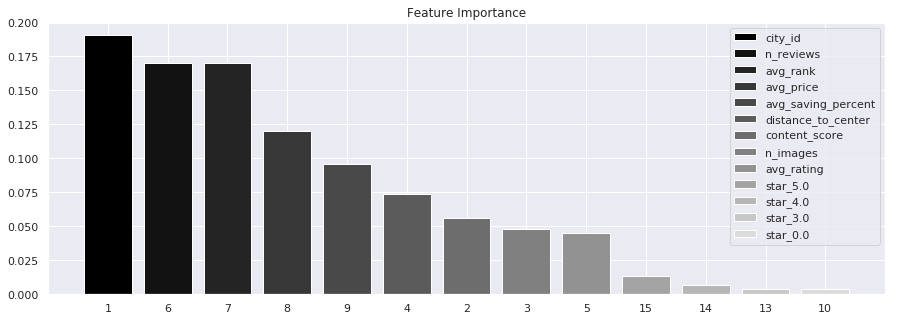

In [64]:
plot_feature_importance(X,importances)

By performing sklearn in-built feature performance analysis we see that according to the basic Random Forest model the most important features w.r.t `n_clicks` are: `city_id`,`avg_rank`,`n_reviews`,`avg_price`,`avg_saving_percent`. Let us recall our correlation matrix and features which we thought would be helpful for classification: `n_reviews`, `avg_saving_percent`,`content_score`,`stars`,`avg_rank`. The once can see along with the feature we would expect to have `avg_rank` and `n_reviews` RF defined other two features to be relevant: `city_id`,`avg_saving_percent`.


### 4) Modeling

In this section, we will build some models and test them. We start with very two simple algorithms DT and KNN in order to establish some baseline and to test whether imputation of 'Nan' is better than just simply deleting 'Nan's' rows.

In [65]:
# Firstly, we need to normalize our data since some of the regression algorithms
# are quite sensitive to the scaling factor


lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=5))

GBoost = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [66]:
# Model Validation

n_folds = 5

def rmse_mae(model):
    
    kf = KFold(n_folds, shuffle=True, random_state=17).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    mae = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = kf))
    
    return rmse,mae

In [67]:
%%time

score_lasso_rmse,score_lasso_mae = rmse_mae(lasso)
score_ridge_rmse,score_ridge_mae = rmse_mae(Ridge)
score_enet_rmse,score_enet_mae = rmse_mae(ENet)
score_xgb_rmse,score_xgb_mae = rmse_mae(model_xgb)
score_lgb_rmse,score_lgb_mae = rmse_mae(model_lgb)

print("Lasso score RMSE: {:.4f} ({:.4f})\n".format(score_lasso_rmse.mean(), score_lasso_rmse.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_rmse.mean(), score_ridge_rmse.std()))
print("ElasticNet score RMSE: {:.4f} ({:.4f})\n".format(score_enet_rmse.mean(), score_enet_rmse.std()))
print("Xgboost score RMSE: {:.4f} ({:.4f})\n".format(score_xgb_rmse.mean(), score_xgb_rmse.std()))
print("LGBM score RMSE: {:.4f} ({:.4f})\n" .format(score_lgb_rmse.mean(), score_lgb_rmse.std()))

print("\nLasso score MAE: {:.4f} ({:.4f})\n".format(score_lasso_mae.mean(), score_lasso_mae.std()))
print("Ridge score MAE: {:.4f} ({:.4f})\n".format(score_ridge_mae.mean(), score_ridge_mae.std()))
print("ElasticNet score MAE: {:.4f} ({:.4f})\n".format(score_enet_mae.mean(), score_enet_mae.std()))
print("Xgboost score MAE: {:.4f} ({:.4f})\n".format(score_xgb_mae.mean(), score_xgb_mae.std()))
print("LGBM score MAE: {:.4f} ({:.4f})\n" .format(score_lgb_mae.mean(), score_lgb_mae.std()))

/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.2427e-17): result may not be accurate.
  overwrite_a=True).T
/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.68857e-17): result may not be accurate.
  overwrite_a=True).T
/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.19036e-17): result may not be accurate.
  overwrite_a=True).T
/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.17118e-17): result may not be accurate.
  overwrite_a=True).T
/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: 

Lasso score RMSE: 118.0815 (18.9865)

Ridge score RMSE: 118.0815 (18.9864)

ElasticNet score RMSE: 118.0815 (18.9866)

Xgboost score RMSE: 103.0596 (16.0557)

LGBM score RMSE: 105.5570 (18.6124)


Lasso score MAE: 4.7997 (0.0510)

Ridge score MAE: 4.7998 (0.0510)

ElasticNet score MAE: 4.7997 (0.0510)

Xgboost score MAE: 4.2329 (0.0278)

LGBM score MAE: 4.3156 (0.0439)

CPU times: user 4h 40min 15s, sys: 14.2 s, total: 4h 40min 29s
Wall time: 48min 37s


Well, apparently xgb boost is working way better than others according to **RMSE** and **MAE** metrics. Lets have a look at the perfomance on the test set.

In [68]:
def rmse(y_pred,y_true):
    result = np.sqrt(mean_squared_error(y_true,y_pred))
    
    return result

def regressions(model):
    
    model.fit(X_train,y_train)
    model_predict = model.predict(X_holdout)
    
    print('MAE : %f' % (mean_absolute_error(y_holdout, model_predict)))
    print('RMSE : %f' % (rmse(y_holdout, model_predict)))
    print('R2 : %f' % (r2_score(y_holdout, model_predict)))

In [69]:
regressions(ENet)

MAE : 23.172347
RMSE : 114.021433
R2 : 0.069438


In [70]:
regressions(lasso)

MAE : 23.172822
RMSE : 114.021420
R2 : 0.069438


In [71]:
regressions(Ridge)

MAE : 23.173649
RMSE : 114.021408
R2 : 0.069439


/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.80474e-17): result may not be accurate.
  overwrite_a=True).T


In [72]:
regressions(model_xgb)

MAE : 17.812497
RMSE : 99.475859
R2 : 0.291716


In [73]:
regressions(model_lgb)

MAE : 18.299053
RMSE : 101.796138
R2 : 0.258289


In [74]:
#Lets find and plot features which are actually important for out XGB model

feature_importance_xgb = model_xgb.feature_importances_
feature_importance_xgb

array([1.5980466e-01, 7.0677608e-02, 8.2547650e-02, 4.6055757e-02,
       4.3342602e-02, 2.3726514e-01, 1.3925253e-01, 7.7460490e-02,
       8.8516586e-02, 6.5115648e-03, 1.3565760e-04, 8.8177441e-04,
       4.1375570e-03, 1.4718849e-02, 2.8691582e-02], dtype=float32)

{'f1': set(['city_id']), 'f2': set(['content_score']), 'f3': set(['n_images']), 'f4': set(['distance_to_center']), 'f5': set(['avg_rating']), 'f6': set(['n_reviews']), 'f7': set(['avg_rank']), 'f8': set(['avg_price']), 'f9': set(['avg_saving_percent']), 'f12': set(['star_2.0']), 'f13': set(['star_3.0']), 'f10': set(['star_0.0']), 'f11': set(['star_1.0']), 'f14': set(['star_4.0']), 'f15': set(['star_5.0'])}
Feature ranking:
0. set(['n_reviews']) 0.237265 
1. set(['city_id']) 0.159805 
2. set(['avg_rank']) 0.139253 
3. set(['avg_saving_percent']) 0.088517 
4. set(['n_images']) 0.082548 
5. set(['avg_price']) 0.077460 
6. set(['content_score']) 0.070678 
7. set(['distance_to_center']) 0.046056 
8. set(['avg_rating']) 0.043343 
9. set(['star_5.0']) 0.028692 
10. set(['star_4.0']) 0.014719 
11. set(['star_0.0']) 0.006512 
12. set(['star_3.0']) 0.004138 


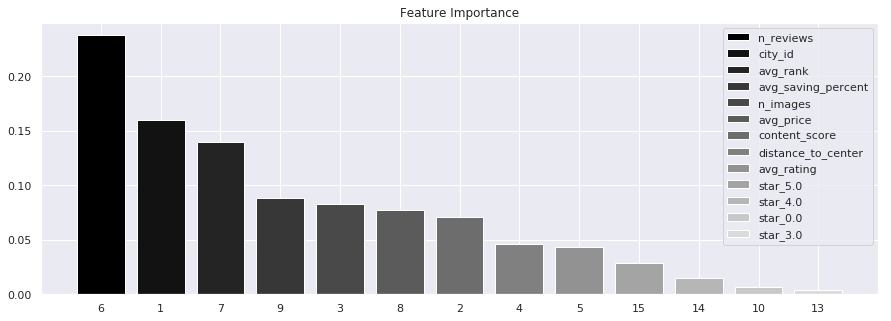

In [75]:
plot_feature_importance(X,feature_importance_xgb)

By performing sklearn in-built feature performance analysis on GB algorithms we see that feature importance has changed. Top-5 features are still the same, however, now
`n_reviews` became the most important feature and has more relative weight.

#### Lets make some predictions with XG boost seems it is working better than others

In [102]:
clicks = validation.n_clicks;
validation_predict = validation.drop('n_clicks', axis=1)
validation_predict.head()

,city_id,content_score,n_images,distance_to_center,avg_rating,n_reviews,avg_rank,avg_price,avg_saving_percent,star_0.0,star_1.0,star_2.0,star_3.0,star_4.0,star_5.0
2,133732.0,39.0,3.0,23491.0,83.0,1005.0,16.438,57.63,27.0,0,0,0,1,0,0
5,52142.0,58.0,2.0,1249.0,87.0,1683.0,18.391,96.70,0.0,1,0,0,0,0,0
15,137544.0,50.0,0.0,11022.0,84.0,315.0,17.600,52.80,0.0,1,0,0,0,0,0
37,30282.0,51.0,0.0,105.0,75.0,201.0,17.088,40.52,0.0,1,0,0,0,0,0
40,54646.0,56.0,0.0,1370.0,76.0,552.0,15.701,68.43,0.0,1,0,0,0,0,0


In [103]:
validation_predict['predicted_clicks'] = model_xgb.predict(validation_predict.values)
validation_predict['predicted_clicks'] = validation_predict['predicted_clicks'].values.round(0)
validation_predict['actual_clicks'] = clicks
validation_predict['clicks_difference'] = validation_predict['actual_clicks'] - validation_predict['predicted_clicks']
validation_predict.head(25)

,city_id,content_score,n_images,distance_to_center,avg_rating,n_reviews,avg_rank,avg_price,avg_saving_percent,star_0.0,star_1.0,star_2.0,star_3.0,star_4.0,star_5.0,predicted_clicks,actual_clicks,clicks_difference
2,133732.0,39.0,3.0,23491.0,83.0,1005.0,16.438,57.63,27.0,0,0,0,1,0,0,0.0,44,44.0
5,52142.0,58.0,2.0,1249.0,87.0,1683.0,18.391,96.70,0.0,1,0,0,0,0,0,6.0,0,-6.0
15,137544.0,50.0,0.0,11022.0,84.0,315.0,17.600,52.80,0.0,1,0,0,0,0,0,3.0,0,-3.0
37,30282.0,51.0,0.0,105.0,75.0,201.0,17.088,40.52,0.0,1,0,0,0,0,0,12.0,10,-2.0
40,54646.0,56.0,0.0,1370.0,76.0,552.0,15.701,68.43,0.0,1,0,0,0,0,0,7.0,4,-3.0
47,28514.0,52.0,1.0,6851.0,70.0,72.0,15.778,60.54,0.0,0,1,0,0,0,0,-7.0,0,7.0
53,28104.0,56.0,1.0,272.0,81.0,234.0,15.171,126.33,37.0,1,0,0,0,0,0,16.0,24,8.0
64,32434.0,59.0,0.0,3683.0,73.0,1371.0,19.889,115.66,12.0,0,0,1,0,0,0,3.0,0,-3.0
71,31910.0,58.0,2.0,1882.0,84.0,1518.0,15.000,50.31,37.0,0,0,1,0,0,0,11.0,0,-11.0
73,49014.0,61.0,1.0,1787.0,88.0,465.0,15.000,73.60,0.0,1,0,0,0,0,0,2.0,0,-2.0


**Conclusion**: In this tutorial, we have worked with hotel clicks prediction. We started with **EDA**, followed by outliers removal and data imputation (which is the redundant step in case of tree-based algorithms). Several algorithms were trained and **feature importance** was observed in order to have a glimpse at what are decisive criteria for customers to click on the hotels. This work can be extended with corresponding HP tuning, which will definitely improve the results. Possibly, there is a room for **feature engineering**, which was not part of this project. Overall we see that tradition GB algorithm is outperforming competitors, however, it still has to be tuned since the one can that the difference between predicted and actual clicks is quite big in a few cases.